@file fakeNews.ipynb
<br>
@author hugomtr
<br>
@brief 
<br>
@version 0.1
<br>
@date 2022-02-28
<br>
@copyright Copyright (c) 2022

# Starting

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 19 13:44:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    14W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import sklearn

# import some classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

# import modules for vectorizing and pipe
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline

# scale data
from sklearn.preprocessing import StandardScaler

# upsampling downsampling
from sklearn.utils import resample

# modules for model selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# modules for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

# modules for vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# others
import itertools
import random

from sklearn.exceptions import ConvergenceWarning

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/FakeNews'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/FakeNews


'/content/gdrive/My Drive/Colab Notebooks/FakeNews'

# Loading a dataset and choose classification


In [86]:
df = pd.read_csv("claimskg.csv",sep=";")
del df['Unnamed: 0']
df.head(2)

,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/36...,'There will be no public funding for abortion ...,2010-03-21,3,True,Bart Stupak,Stupak revises abortion stance on health care ...,"Abortion rights,Barack Obama,Bart Stupak,Ben N...",abortion,"Abortion,Health Care",politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
1,http://data.gesis.org/claimskg/claim_review/e6...,Central Health 'is the only hospital district ...,2011-03-15,3,True,Wayne Christian,State Rep. Wayne Christian says Central Health...,"Austin American-Statesman,Harris County Hospit...",NaN,Abortion,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English


In [87]:
df = pd.read_csv("claimskg.csv",sep=";")
del df['Unnamed: 0']

def f(x):
  if x==1:
    return 0
  if x==2:
    return 2
  return 1

def g(x):
  if x==1 or x==0:
    return 0
  else: 
    return 1

def gbis(x):
  if x=="True" or x=="False":
    return "True_False"
  else: 
    return "MIXTURE"

def choose_classification():
  print("Select which classification you want:")
  print("0 : {True} vs {False}")
  print("1 : {True,False} vs {Mixture}")
  print("2 : {True} vs {False} vs {Mixture}")
  n = int(input("select a number: "))
  return n

def resample_(n,df):
  
  if n == 0:
    # {True} vs {False}
    df = df[df.truthRating.isin([0,1])]
    df.groupby("ratingName").size().plot(kind='pie',y='ratingName',label = "Classe",autopct='%1.1f%%',title= "Downsampling or Upsampling  is needed?")
    plt.show()
    true_data = df[df.ratingName == "True"]
    false_data = df[df.ratingName == "False"]
    
    # downsampling false data
    false_data = false_data.sample(len(true_data))
    df = pd.concat([true_data,false_data])
    df.groupby("ratingName").size().plot(kind='pie',y='ratingName',label = "Classe",autopct='%1.1f%%',title= "After resampling")
    plt.show()
  
  if n == 1:
    # {True,False} vs {Mixture}
    df["truthRating"] = df["truthRating"].apply(g)
    df["ratingName"] = df["ratingName"].apply(gbis)
    df.groupby("ratingName").size().plot(kind='pie',y='ratingName',label = "Classe",autopct='%1.1f%%',title= "Downsampling or Upsampling  is needed?")
    plt.show()
    true_false_data = df[df.ratingName == "True_False"]
    mixture_data = df[df.ratingName == "MIXTURE"]
    
    # downsampling mixture data
    true_false_data = true_false_data.sample(len(mixture_data))
    df = pd.concat([true_false_data,mixture_data])
    df.groupby("ratingName").size().plot(kind='pie',y='ratingName',label = "Classe",autopct='%1.1f%%',title= "After resampling")
    plt.show()

  if n == 2:
    # {True} vs {False} vs {Mixture}
    df.groupby("ratingName").size().plot(kind='pie',y='ratingName',label = "Classe",autopct='%1.1f%%',title= "Downsampling or Upsampling  is needed?")
    plt.show()
    true_data = df[df.ratingName == "True"]
    false_data = df[df.ratingName == "False"]
    mixture_data = df[df.ratingName == "MIXTURE"]

    # downsampling false data
    false_data = false_data.sample(len(true_data))
    mixture_data = mixture_data.sample(len(true_data))
    df = pd.concat([true_data,false_data,mixture_data])
    df.groupby("ratingName").size().plot(kind='pie',y='ratingName',label = "Classe",autopct='%1.1f%%',title= "After resampling")
    plt.show()
  return df

Select which classification you want:
0 : {True} vs {False}
1 : {True,False} vs {Mixture}
2 : {True} vs {False} vs {Mixture}
select a number: 1


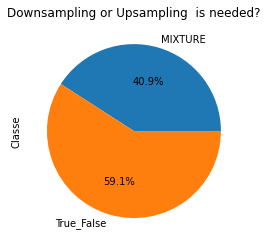

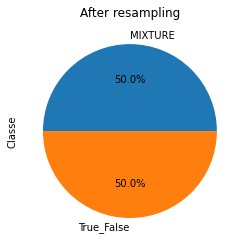

classes : ['True_False' 'MIXTURE'] n° rows df : 20000


In [88]:
df["truthRating"] = df["truthRating"].apply(f)

n = choose_classification()

df = resample_(n,df)

classes = df.ratingName.unique()

label_dict = {}
for index, possible_label in enumerate(classes):
    label_dict[possible_label] = index

df['label'] = df.ratingName.replace(label_dict)
df["text"] = df["text"] + " " +  df["author"] + " " + df["headline"] +  " " + df["source"]
df = df[["text","label","ratingName"]]

train, test = train_test_split(df, test_size=0.1, shuffle=True)
print("classes :",classes,"n° rows df :", len(df))

In [89]:
# Saving Data in 2 csv file
train.to_csv("train.csv",sep=';')
test.to_csv("test.csv",sep=';')

# Ingenierie Textuelle

### Installation Packages & Loading Data

In [90]:
!pip install langdetect 
!pip install contractions

In [91]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys

import contractions

# librairie BeautifulSoup
from bs4 import BeautifulSoup

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

## detection de language
import langdetect 

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import RegexpParser

# il est possible de charger l'ensemble des librairies en une seule fois 
# décocher le commentaire de la ligne ci-dessous
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
nltk.download('tagsets')
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from spacy.tokens import Span
# il faut sélectionner pour quelle langue les traitements vont être faits.
nlp = spacy.load('en')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
# Loading training set and testing set
df_train = pd.read_csv("train.csv",sep=";")
df_test = pd.read_csv("test.csv",sep=";")

del df_train['Unnamed: 0'];del df_test['Unnamed: 0']

### Text Preprocessing class and function





In [93]:
# text = np.concatenate((df_train["text"],df_test["text"]))

# def contains_digit(word):
#   for c in word:
#     if c.isdigit():
#       return True
#   return False

# stopwords = np.array(nltk.corpus.stopwords.words('english'))

# for i,sentence in zip(range(len(text)),text):
#   # Removing punctuation
#   tokenizer = nltk.RegexpTokenizer(r"\w+")
#   sentence = tokenizer.tokenize(sentence)

#   sentence = " ".join(sentence)
#   sentence = re.sub(r'Unknown', '', str(sentence))

#   sentence = word_tokenize(sentence)

#   # converting each word to lowercase
#   sentence = [word.lower() for word in sentence if not word in stopwords]

#   # Removing stopwords
#   sentence = [word for word in sentence if not word in stopwords]

#   # Removing word with only one letter
#   sentence = [word for word in sentence if len(word) != 1]

#   # Removing word with digits
#   sentence = [word for word in sentence if not contains_digit(word)]

#   # stemmer words 
#   # lemmatizer = WordNetLemmatizer()
#   ps = PorterStemmer()
#   sentence = [ps.stem(word) for word in sentence]

#   ## Removing pronouns infinitive verbs dt...
#   # for word in nltk.pos_tag(sentence):
#   #   word_to_keep = []
#   #   if word[1] not in ['IN', 'PP', 'DT','PRP$','VB','MD']:
#   #     word_to_keep.append(word[0])
  
#   sentence = (" ").join(sentence)
#   text[i] = sentence

In [94]:
from sklearn.base import BaseEstimator, TransformerMixin

def MyCleanText(X, 
  lowercase=False, # mettre en minuscule
  removestopwords=False, # supprimer les stopwords
  removedigit=False, # supprimer les nombres 
  getstemmer=False, # conserver la racine des termes
  getlemmatisation=False # lematisation des termes 
  ):

  sentence=str(X)

  # suppression des caractères spéciaux
  sentence = re.sub(r'[^\w\s]',' ', sentence)
  # suppression de tous les caractères uniques
  sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
  # substitution des espaces multiples par un seul espace
  sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)
  # subtitution of Unknown
  sentence = re.sub(r'Unknown', '', sentence)

  # remove some space
  sentence = sentence.strip()

  # decoupage en mots
  tokens = word_tokenize(sentence)
  if lowercase:
    tokens = [token.lower() for token in tokens]

  # suppression ponctuation
  table = str.maketrans('', '', string.punctuation)
  words = [token.translate(table) for token in tokens]

  # suppression des tokens non alphabetique ou numerique
  words = [word for word in words if word.isalnum()]

  # suppression des tokens numerique
  if removedigit:
    words = [word for word in words if not word.isdigit()]

  # suppression des stopwords
  if removestopwords:
    stopwords = np.array(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if not word in stopwords]

  # lemmatisation
  if getlemmatisation:
    lemmatizer=WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word)for word in words]


  # racinisation
  if getstemmer:
    ps = PorterStemmer()
    words=[ps.stem(word) for word in words]

    sentence= ' '.join(words)

  return sentence 

class TextNormalizer(BaseEstimator, TransformerMixin):
  def __init__(self, 
    removestopwords=False, # suppression des stopwords
    lowercase=False,# passage en minuscule
    removedigit=False, # supprimer les nombres 
    getstemmer=False,# racinisation des termes 
    getlemmatisation=False # lemmatisation des termes 
    ):
  
    self.lowercase=lowercase
    self.getstemmer=getstemmer
    self.removestopwords=removestopwords
    self.getlemmatisation=getlemmatisation
    self.removedigit=removedigit
    

  def transform(self, X, **transform_params):
    # Nettoyage du texte
    X=X.copy() # pour conserver le fichier d'origine
    return [MyCleanText(text,lowercase=self.lowercase,
    getstemmer=self.getstemmer,
    removestopwords=self.removestopwords,
    getlemmatisation=self.getlemmatisation,
    removedigit=self.removedigit) for text in X]

  def fit(self, X, y=None, **fit_params):
    return self
  
  def fit_transform(self, X, y=None, **fit_params):
    return self.fit(X).transform(X)

  def get_params(self, deep=True):
    return {
    'lowercase':self.lowercase,
    'getstemmer':self.getstemmer,
    'removestopwords':self.removestopwords,
    'getlemmatisation':self.getlemmatisation,
    'removedigit':self.removedigit
    } 
  
  def set_params (self, **parameters):
    for parameter, value in parameters.items():
      setattr(self,parameter,value)
    return self 



In [95]:
def preprocess_selection(model_name,model,X,y,lowercase=False):
    CV_brut = Pipeline([('cleaner', TextNormalizer()), 
                        ('count_vectorizer', CountVectorizer(lowercase=False)),
                        (model_name, model)])
    CV_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    CV_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    CV_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    
    CV_lowStopna = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=True)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    TFIDF_lowStopna = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=True)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    all_models = [
        ("CV_brut", CV_brut),
        ("CV_lowcase", CV_lowcase),
        ("CV_lowStop", CV_lowStop),
        ("CV_lowStopstem",CV_lowStopstem),
        ("CV_lowStopna",CV_lowStopna),
        ("TFIDF_lowStopna", TFIDF_lowStopna),
        ("TFIDF_lowcase", TFIDF_lowcase),
        ("TFIDF_lowStop", TFIDF_lowStop),
        ("TFIDF_lowStopstem",TFIDF_lowStopstem),
        ("TFIDF_brut", TFIDF_brut),
    ]

    print ("Evaluation des différentes configurations : ")
    unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
    scores = sorted(unsorted_scores, key=lambda x: -x[1])


    print(tabulate(scores, floatfmt='.4f', headers=('Pipeline', 'Score')))

### Selecting best preprocessing
OPTIONAL!
WARNING !!!
<br>
May take some minutes
<br>
example below ->

In [96]:
X = df_train["text"]
y = df_train["label"] 

X_s = X.sample(500)
y_s = y.loc[X_s.index]
preprocess_selection("multinomial_nb",MultinomialNB(),X_s,y_s)

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
CV_brut             0.6880
CV_lowcase          0.6880
CV_lowStop          0.6880
TFIDF_lowcase       0.6740
TFIDF_lowStop       0.6740
TFIDF_brut          0.6740
TFIDF_lowStopstem   0.6640
TFIDF_lowStopna     0.6620
CV_lowStopstem      0.6620
CV_lowStopna        0.6600


# ACP Visualisation des données

In [97]:
X = df_train["text"]
y = df_train["label"]
text_normalizer= TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False) 
X=text_normalizer.fit_transform(X)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

variance ratio:  [0.00263871 0.0048602 ]
variance ratio sum:  0.007498915120928741
singular values: [17.94902556  9.28435156]


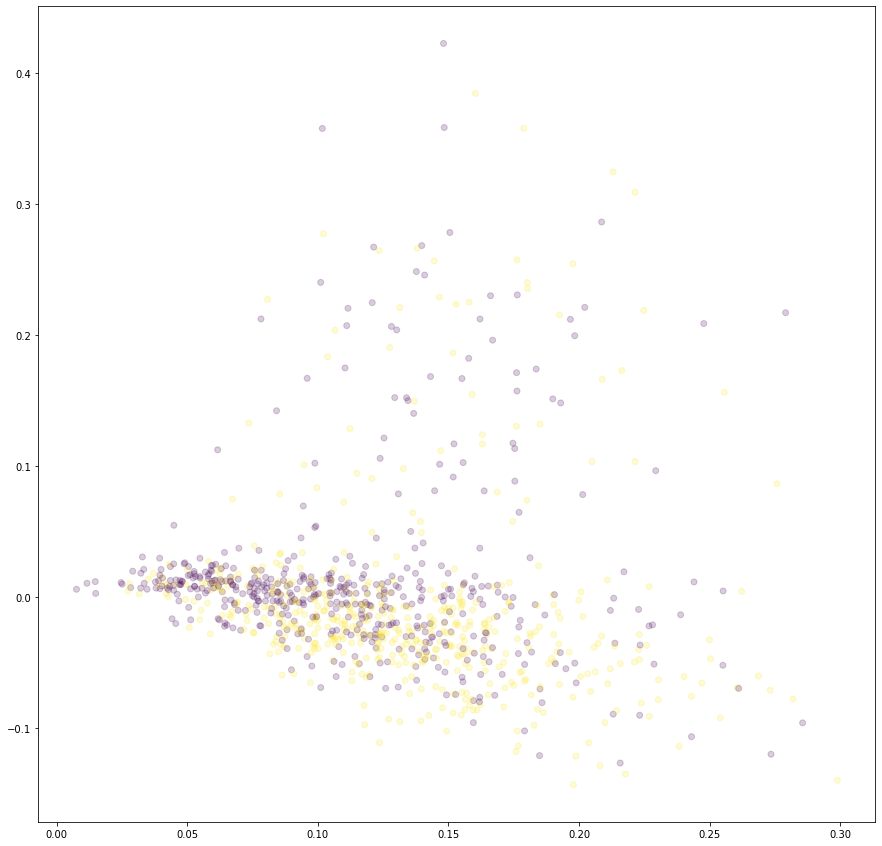

In [98]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)

print("variance ratio: ",svd.explained_variance_ratio_)

print("variance ratio sum: ",svd.explained_variance_ratio_.sum())
print("singular values:" ,svd.singular_values_)
fig,ax = plt.subplots(figsize=(15,15))
ax.scatter(X_svd[:1000,0], X_svd[:1000,1], alpha=0.2,c=y[:1000])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  """


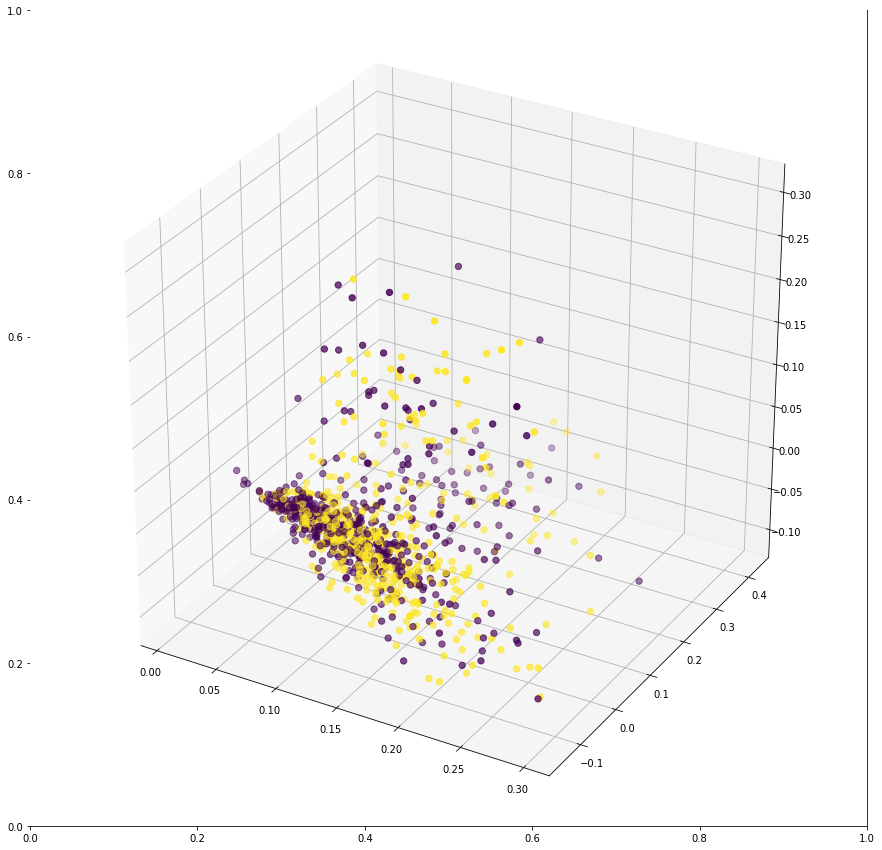

In [99]:
from mpl_toolkits.mplot3d import Axes3D
svd = TruncatedSVD(n_components=3)
X_svd = svd.fit_transform(X)
fig,ax = plt.subplots(figsize = (15,15))
ax = fig.gca(projection='3d')
ax.scatter(X_svd[:1000,0],X_svd[:1000,1],
     X_svd[:1000,2],
     zdir='z',s=40,depthshade=True,c=y[:1000])
plt.show()

# Premières approches 

In [22]:
def plot_confusion_matrix(cm, classes=classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = 2*cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_quad_error(X,y,model):
  arr1=[];arr2=[]
  size = np.linspace(500,int(len(X)),25).astype('int32')
  for m in size:
    X_s = X.sample(m)
    y_s = y.loc[X_s.index]
    X_train,X_val,y_train,y_val = train_test_split(X_s,y_s,train_size=0.8,random_state=0)
    clf = model.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    squarred_error_train = (1/len(y_pred_train))*np.sum((y_pred_train - y_train)**2)
    squared_error_CV = (1/len(y_pred_val))*np.sum((y_pred_val - y_val)**2)
    arr1.append(squarred_error_train)
    arr2.append(squared_error_CV)

  plt.plot(size,arr1,label='train error')
  plt.plot(size,arr2,label='cv error')
  plt.xlabel("Training Size")
  plt.gca().set_xlim([100,len(X)])
  plt.ylabel("Quadratic Error")
  plt.title("Model Evaluation")
  plt.legend()
  plt.show()

## Logistic Regression special application (only for True vs False)

### special preprocessing based on frequency transformation

Before running the classifier we need to compute the fake frequency and non fake frequency of each word. By this I mean counting each word appareance in the fake corpus (set of all fake post) and in the non fake corpus (set of all non fake post. From approximatively 3000 features one corresponding to each word we are now only dealing with 2.

In [77]:
# Last step of preprocessing = vectorizing the text
text = np.concatenate((df_train["text"],df_test["text"]))
label = np.concatenate((df_train["label"],df_test["label"]))

arr = [i for i in range(len(df_train)+len(df_test))]
idx = np.random.choice(arr,300)
text = np.concatenate((df_train["text"],df_test["text"]))
text = text[idx]
label = label[idx]

text_normalizer=TextNormalizer(lowercase=True)  
text=text_normalizer.fit_transform(text)
text = np.array(text)

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(text)
corpus = np.array(vectorizer.get_feature_names())

In [78]:
def get_fake_no_fake_text(text):
  fake_text = np.array(text[label == 0])
  non_fake_text = np.array(text[label == 1])
  return fake_text,non_fake_text

def compute_frequency(fake_text,non_fake_text):
  # Computes 2 different frequency use of dictionary for O(1) time acces to value of a paticular word
  fake_text = " ".join(fake_text)
  fake_text = word_tokenize(fake_text)
  non_fake_text = " ".join(non_fake_text)
  non_fake_text = word_tokenize(non_fake_text)
  corpus = np.unique(np.concatenate((fake_text,non_fake_text),axis=0))

  FakeFreq = {w:0 for w in corpus}
  NonFakeFreq = {w:0 for w in corpus}

  for word in fake_text:
    FakeFreq[word] += 1

  for word in non_fake_text:
    NonFakeFreq[word] += 1

  return FakeFreq,NonFakeFreq

Before running the logistic regression algorithm we need to compute the frequency of each word in the 2 corpus
<br>

The training example will the have the following format with 1 for the bias term. 
$$ X^{(i)} = \begin{pmatrix}
1 \\
X_{Fake}^{(i)} \\
X_{NoFake}^{(i)} 
\end{pmatrix} $$


In [79]:
fake_text,non_fake_text= get_fake_no_fake_text(text)
FakeFreq,NonFakeFreq = compute_frequency(fake_text,non_fake_text)

In [80]:
def feat_extraction_fake(row):
  row_text = word_tokenize(row)
  sum_fake_freq = 0
  for word in row_text:
    sum_fake_freq += FakeFreq[word]
  return sum_fake_freq

def feat_extraction_no_fake(row):
  row_text = word_tokenize(row)
  sum_non_fake_freq = 0
  for word in row_text:
    sum_non_fake_freq += NonFakeFreq[word]
  return sum_non_fake_freq

In [81]:
dfbis_train = pd.DataFrame(text,columns=["text"])
dfbis_train["bias"] = 1
dfbis_train["fake"] = dfbis_train["text"].apply(feat_extraction_fake)
dfbis_train["no fake"] = dfbis_train["text"].apply(feat_extraction_no_fake)

X = dfbis_train[["fake","no fake"]]
y = pd.DataFrame(label,columns=["truthRating"])

Logistic Regression implementation:
<br>
In short we are the trying to minimize the following cost function with the help to the famous gradient descent algorithm.
<br>
$$ J(θ) = -\dfrac{1}{m}*\sum_{i=1}^{m}[ \log h(x^{(i)},θ) + (1 - y^{(i)})*log(1 - h(x^{(i)},θ))] $$
<br>
with h the sigmoid function define as follow $$ h(x^{i},θ) = \dfrac{1}{1 + e^{-θ^{T}*x^{(i)}}} $$

<br>

$m =$ number of training examples
<br>

$x(i) =$ i-th example of the training set 
<br>

Thus we make sure to resolve a convex problem and by this gradient descent find a global minima.

Training

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_val)

target_names = ["No Fake","Fake"]

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred, target_names=target_names))

In [ ]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), classes=["Fake","No Fake"])

Etant donnée la simplicité de nos features seulement 2 il n'est pas nécesaire ici d'appliquer des algorithmes de classifications plus performant sachant qu'ici une simple regression répond très bien à notre problème.

## Naives Bayes

<br>

Naives Bayes Approach Inference Rules for binary classification.
<br>

$$\prod_{i=1}^{n} \dfrac{P \left( wi \middle| \ Fake \right)}{P \left( wi \middle| \ NonFake \right)}$$
<br>
This expression says that we're going to take the product across all of the words (n words) in a post of the probability for each word in the fake class divide it by the probability in the non fake class
<br>

Laplacian Smoothing technique to avoid zero probability issue with the formula above
<br>

$$P \left( wi \middle| \ class \right) = \dfrac{freq(wi,class)+1}{Nc + Vc} \\ class \in \{ Fake , Non Fake \} $$
<br>

$N_c = \ $frequency of all words in class 
class
<br>

​$V =\ $number of unique words in vocabulary
<br>

In [100]:
X = df_train["text"]
y = df_train["ratingName"] 

text_normalizer= TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=True) 
X=text_normalizer.fit_transform(X)

In [101]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.7,random_state=0)

nb = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=classes))

accuracy 0.6874074074074074
              precision    recall  f1-score   support

  True_False       0.66      0.78      0.71      2674
     MIXTURE       0.73      0.60      0.66      2726

    accuracy                           0.69      5400
   macro avg       0.69      0.69      0.69      5400
weighted avg       0.69      0.69      0.68      5400



# ML Comparaison de tous les classifieurs

## Cross Validation

In [ ]:
X = df_train["text"]
y = df_train["label"]
# found when testing different parameters in the preprocessing  
text_normalizer= TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False) 
X=text_normalizer.fit_transform(X)

models = []
models.append(('LRegression', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('MultinomialNB', MultinomialNB()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('SGDClassifier',SGDClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('PassiveAggressiveClassifier',PassiveAggressiveClassifier()))

In [ ]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=5, shuffle=True)
  model = make_pipeline(TfidfVectorizer(), model)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LRegression: 0.710167 (0.006556)
KNN: 0.641500 (0.006495)
MultinomialNB: 0.704278 (0.009004)
DecisionTreeClassifier: 0.633611 (0.004910)
SVM: 0.715278 (0.010401)
SGDClassifier: 0.713944 (0.011506)
RandomForest: 0.716111 (0.006351)
PassiveAggressiveClassifier: 0.629556 (0.005448)


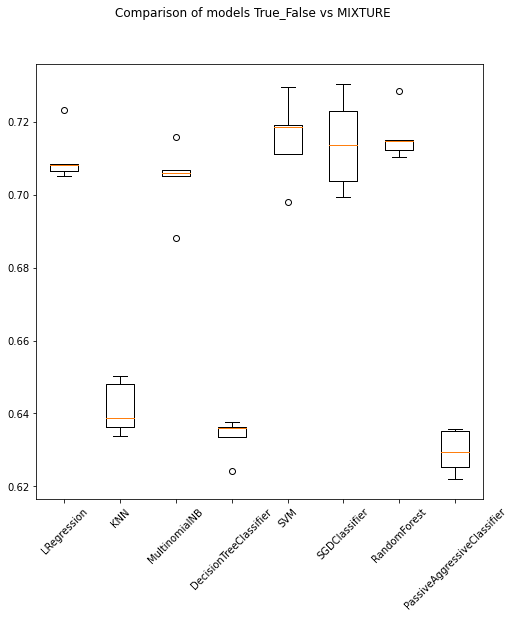

In [ ]:
fig = plt.figure(figsize=(8,8))
if len(classes)>2:
  fig.suptitle('Comparison of models {} vs {} vs {}'.format(classes[0],classes[1],classes[2]))
else:
  fig.suptitle('Comparison of models {} vs {}'.format(classes[0],classes[1]))  
ax = fig.add_subplot(111)
ax.boxplot(results)
ax.set_xticklabels(names,rotation = 45)
plt.show()

## Grid Search CV affinement des meilleurs paramètres



### Logistic Regression

In [112]:
X = df_train["text"]
y = df_train["label"] 

X_s = X.sample(1000)
y_s = y.loc[X_s.index]
preprocess_selection("logistic_regression",LogisticRegression(),X_s,y_s)

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
TFIDF_lowcase       0.7000
TFIDF_lowStop       0.7000
TFIDF_brut          0.7000
TFIDF_lowStopstem   0.6890
TFIDF_lowStopna     0.6880
CV_brut             0.6720
CV_lowcase          0.6720
CV_lowStop          0.6720
CV_lowStopstem      0.6570
CV_lowStopna        0.6510


In [119]:
X = df_train["text"]
y = df_train["label"]

# put text normalizer in the pipe is a bad idea because of the very long time processing
text_normalizer = TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False)
X = text_normalizer.fit_transform(X)

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

pipe = Pipeline([('vect', TfidfVectorizer()),
               ('clf', LogisticRegression(solver='lbfgs')),
               ])

grid = {"clf__penalty": ['l2' ,'none'],
        "clf__C":np.logspace(-2,2,4),
        "clf__max_iter":[100,1000]}

gd_srLR = GridSearchCV(pipe,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                    return_train_score=True)

gd_srLR.fit(X_train, y_train)
print('meilleur score ',
 gd_srLR.best_score_,'\n')
print('meilleurs paramètres',
 gd_srLR.best_params_,'\n')
print('meilleur estimateur',
gd_srLR.best_estimator_,'\n')

meilleur score  0.7063194444444445 

meilleurs paramètres {'clf__C': 0.21544346900318834, 'clf__max_iter': 100, 'clf__penalty': 'l2'} 

meilleur estimateur Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=0.21544346900318834))]) 




 accuracy:  0.7105555555555556 


               precision    recall  f1-score   support

  True_False       0.74      0.66      0.70      1815
     MIXTURE       0.69      0.76      0.72      1785

    accuracy                           0.71      3600
   macro avg       0.71      0.71      0.71      3600
weighted avg       0.71      0.71      0.71      3600

Confusion matrix, without normalization


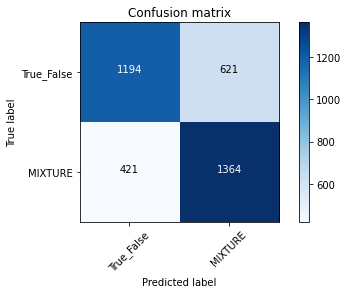

In [120]:
# Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
lr = gd_srLR.best_estimator_

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

print('\n',classification_report(y_val, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_val, y_pred),classes = classes)

Overfitting, Underfitting ?

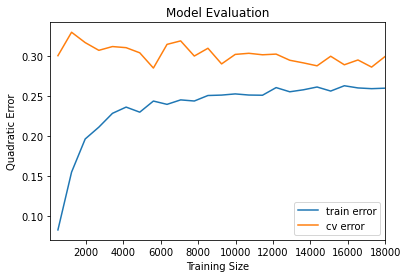

In [121]:
X = df_train["text"]
y = df_train["label"]
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X = pd.Series(X)
plot_quad_error(X,y,lr)

Evaluation sur le test set


 accuracy:  0.6795 


               precision    recall  f1-score   support

  True_False       0.68      0.68      0.68      1001
     MIXTURE       0.68      0.68      0.68       999

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000

Confusion matrix, without normalization


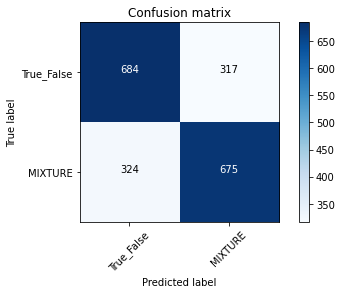

In [122]:
X_test,y_test = df_test["text"],df_test["label"]
y_pred = lr.predict(X_test)
print('\n accuracy: ', accuracy_score(y_pred, y_test),'\n')

print('\n',classification_report(y_test, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes = classes)

### SVC

In [123]:
X = df_train["text"]
y = df_train["label"] 

X_s = X.sample(1000)
y_s = y.loc[X_s.index]
preprocess_selection("SVC",SVC(),X_s,y_s)

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
CV_lowStopstem      0.7020
CV_lowStopna        0.7000
CV_brut             0.6980
CV_lowcase          0.6980
CV_lowStop          0.6980
TFIDF_lowStopstem   0.6920
TFIDF_lowcase       0.6910
TFIDF_lowStop       0.6910
TFIDF_brut          0.6910
TFIDF_lowStopna     0.6830


In [125]:
X = df_train["text"]
y = df_train["label"]
# put text normalizer in the pipe is a bad idea because of the very long time processing
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

pipe = Pipeline([('vect', TfidfVectorizer()),
               ('clf', SVC()),
              ])

grid = {'clf__C': [100, 1000], 
        'clf__kernel': ['linear'],
        'clf__gamma': [0.001, 0.0001], 
        'clf__kernel': ['rbf']}

gd_srSVC = GridSearchCV(pipe,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                    return_train_score=True)

gd_srSVC.fit(X_train, y_train)
print('meilleur score ',
 gd_srSVC.best_score_,'\n')
print('meilleurs paramètres',
 gd_srSVC.best_params_,'\n')
print('meilleur estimateur',
gd_srSVC.best_estimator_,'\n')


meilleur score  0.7109722222222221 

meilleurs paramètres {'clf__C': 100, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'} 

meilleur estimateur Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', SVC(C=100, gamma=0.001))]) 




 accuracy:  0.7113888888888888 


               precision    recall  f1-score   support

  True_False       0.76      0.63      0.69      1815
     MIXTURE       0.68      0.80      0.73      1785

    accuracy                           0.71      3600
   macro avg       0.72      0.71      0.71      3600
weighted avg       0.72      0.71      0.71      3600

Confusion matrix, without normalization


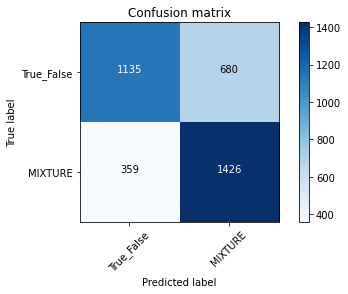

In [126]:
# Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
lr = gd_srSVC.best_estimator_

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

print('\n',classification_report(y_val, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_val, y_pred),classes = classes)

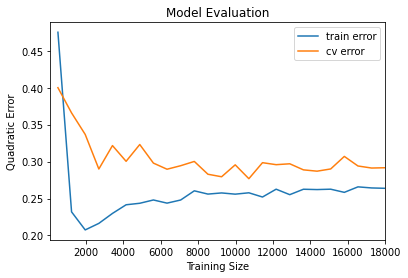

In [127]:
X = df_train["text"]
y = df_train["label"]
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X = pd.Series(X)
plot_quad_error(X,y,lr)


 accuracy:  0.698 


               precision    recall  f1-score   support

  True_False       0.75      0.60      0.66      1001
     MIXTURE       0.66      0.80      0.73       999

    accuracy                           0.70      2000
   macro avg       0.71      0.70      0.69      2000
weighted avg       0.71      0.70      0.69      2000

Confusion matrix, without normalization


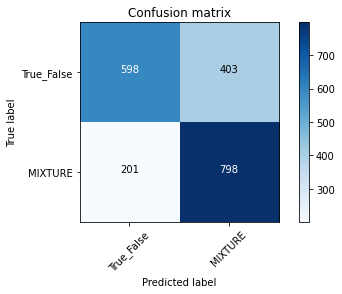

In [128]:
X_test,y_test = df_test["text"],df_test["label"]
y_pred = lr.predict(X_test)
print('\n accuracy: ', accuracy_score(y_pred, y_test),'\n')

print('\n',classification_report(y_test, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes = classes)

### MultinomialNB

In [129]:
X = df_train["text"]
y = df_train["label"] 

X_s = X.sample(1000)
y_s = y.loc[X_s.index]
preprocess_selection("MuntinomialNB",MultinomialNB(),X_s,y_s)

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
TFIDF_lowcase       0.6700
TFIDF_lowStop       0.6700
TFIDF_brut          0.6700
CV_brut             0.6680
CV_lowcase          0.6680
CV_lowStop          0.6680
TFIDF_lowStopna     0.6680
TFIDF_lowStopstem   0.6650
CV_lowStopstem      0.6570
CV_lowStopna        0.6530


In [130]:
X = df_train["text"]
y = df_train["label"]
# put text normalizer in the pipe is a bad idea because of the very long time processing
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

pipe = Pipeline([('vect', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

grid = {'clf__alpha': np.linspace(0.5, 1.5, 6),
        'clf__fit_prior': [True, False],}

gd_srMNB = GridSearchCV(pipe,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                    return_train_score=True)

gd_srMNB.fit(X_train, y_train)
print('meilleur score ',
 gd_srMNB.best_score_,'\n')
print('meilleurs paramètres',
 gd_srMNB.best_params_,'\n')
print('meilleur estimateur',
gd_srMNB.best_estimator_,'\n')

meilleur score  0.7000694444444444 

meilleurs paramètres {'clf__alpha': 1.1, 'clf__fit_prior': False} 

meilleur estimateur Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', MultinomialNB(alpha=1.1, fit_prior=False))]) 




 accuracy:  0.6991666666666667 


               precision    recall  f1-score   support

  True_False       0.75      0.60      0.67      1815
     MIXTURE       0.66      0.80      0.73      1785

    accuracy                           0.70      3600
   macro avg       0.71      0.70      0.70      3600
weighted avg       0.71      0.70      0.70      3600

Confusion matrix, without normalization


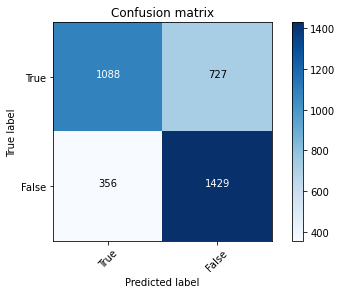

In [131]:
#Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
lr = gd_srMNB.best_estimator_

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

print('\n',classification_report(y_val, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_val, y_pred))

Overfitting underfitting ?

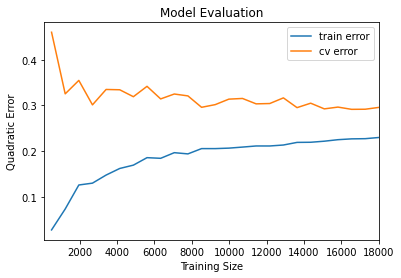

In [132]:
X = df_train["text"]
y = df_train["label"]
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X = pd.Series(X)
plot_quad_error(X,y,lr)

Evaluation sur le test Set


 accuracy:  0.6735 


               precision    recall  f1-score   support

  True_False       0.70      0.62      0.66      1001
     MIXTURE       0.66      0.73      0.69       999

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000

Confusion matrix, without normalization


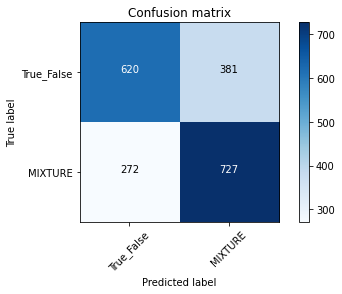

In [133]:
X_test,y_test = df_test["text"],df_test["label"]
y_pred = lr.predict(X_test)
print('\n accuracy: ', accuracy_score(y_pred, y_test),'\n')

print('\n',classification_report(y_test, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes = classes)

### RandomForest

In [ ]:
# X = df_train["text"]
# y = df_train["truthRating"]
# text_normalizer= TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False) 
# X=text_normalizer.fit_transform(X)

In [ ]:
# X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.7,random_state=0)

# pipe = Pipeline([('vect', TfidfVectorizer()),
#                ('clf', RandomForestClassifier()),
#               ])
# grid = { 
#     'clf__n_estimators': [100,200],
#     'clf__max_features': ['auto', 'sqrt', 'log2'],
#     'clf__max_depth' : [7,8],
#     'clf__criterion' :['gini', 'entropy']
# }
# gd_srLR = GridSearchCV(pipe,  
#                      param_grid=grid,
#                      scoring='accuracy',
#                      cv=5,
#                      n_jobs=-1,
#                     return_train_score=True)

# gd_srLR.fit(X_train, y_train)
# print ('meilleur score ',
#  gd_srLR.best_score_,'\n')
# print ('meilleurs paramètres',
#  gd_srLR.best_params_,'\n')
# print ('meilleur estimateur',
# gd_srLR.best_estimator_,'\n')

In [ ]:
# # Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
# lr = gd_srLR.best_estimator_

# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_val)
# print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

# print('\n',classification_report(y_val, y_pred,target_names=classes))
# plot_confusion_matrix(confusion_matrix(y_val, y_pred),classes = classes)

# Deep learning 

### LSTM

In [ ]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

In [ ]:
X = df_train["text"]
y = df_train["ratingName"]

text_normalizer= TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False) 
X=text_normalizer.fit_transform(X)

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(X)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
y = pd.get_dummies(y).values
print('Shape of label tensor:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


Found 15951 unique tokens.
Shape of data tensor: (18000, 250)
Shape of label tensor: (18000, 2)
(16200, 250) (16200, 2)
(1800, 250) (1800, 2)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
228/228 [==============================] - 185s 800ms/step - loss: 0.6014 - accuracy: 0.6892 - 

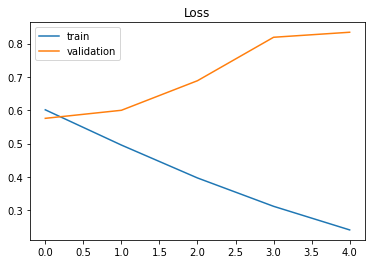

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

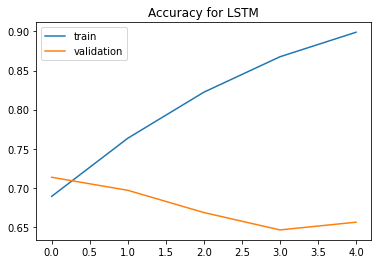

In [ ]:
plt.title('Accuracy for LSTM')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

### Fine tuning BERT

In [ ]:
import torch
from tqdm.notebook import tqdm
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train.index.values, df_train.label.values, test_size=0.15, random_state=0, stratify=df_train.label.values)

df_train.loc[X_train, 'data_type'] = 'train'
df_train.loc[X_val, 'data_type'] = 'val'

df_train.groupby(['ratingName', 'label', 'data_type']).count()

text
ratingName label data_type      
MIXTURE    1     train      7633
                 val        1347
True_False 0     train      7667
                 val        1353

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df_train[df_train.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_train[df_train.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt' 
)

encoded_data_test = tokenizer.batch_encode_plus(
    df_test.text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt' 
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train[df_train.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_train[df_train.data_type=='val'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df_test.label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# We will use Random sampler for train set and sequential sampler for validation
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5100 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6032378639339232
Validation loss: 0.5520518823133574
F1 Score (Weighted): 0.7376971644581366


Epoch 2:   0%|          | 0/5100 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6452898763619619
Validation loss: 0.6244996976945549
F1 Score (Weighted): 0.7295408825928789


Epoch 3:   0%|          | 0/5100 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6161106822735803
Validation loss: 1.0558359705778355
F1 Score (Weighted): 0.7332168755061854


Epoch 4:   0%|          | 0/5100 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.46706435399894675
Validation loss: 1.4080368120317064
F1 Score (Weighted): 0.7246506335204997


Epoch 5:   0%|          | 0/5100 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.33599939528277756
Validation loss: 1.599794949629884
F1 Score (Weighted): 0.7159074153816883


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_test)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: True_False
Accuracy: 657/980

Class: MIXTURE
Accuracy: 785/1020

